# Day 4 Advanced: Continue Training - Push to 95%!

**Goal:** Continue training ResNet50 and DenseNet121 for more epochs to achieve 95% accuracy

**Current Status:**
- ResNet50: 91.87% (trained for 30 epochs)
- DenseNet121: 88.24% (trained for 30 epochs)
- Ensemble + Aggressive TTA: 93.64%

**Target:**
- ResNet50: 92.5-93.0% (+10 epochs)
- DenseNet121: 89.0-90.0% (+10 epochs)
- Ensemble + Aggressive TTA: **94.5-95.5%** 🎯

**Strategy:**
1. Load existing trained models
2. Continue Phase 3 fine-tuning with lower learning rate
3. Use early stopping to prevent overfitting
4. Save improved models
5. Re-evaluate ensemble with new models

**Expected time:** 2-3 hours

---

## 1. Import Libraries

In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Add src to path
sys.path.append('../../src')
from training.transfer_learning_utils import create_rgb_generators

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU available: {len(gpus)} GPU(s)")
    print(f"   GPU: {gpus[0].name}")
else:
    print("⚠️  No GPU - training will be much slower")

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

2025-10-25 00:15:22.800966: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
Keras version: 3.11.3
✅ GPU available: 1 GPU(s)
   GPU: /physical_device:GPU:0


## 2. Configuration

In [2]:
# Paths
TRAIN_CSV = "../../outputs/data_splits/train_split.csv"
VAL_CSV = "../../outputs/data_splits/val_split.csv"
TEST_CSV = "../../outputs/data_splits/test_split.csv"

MODEL_DIR = "../../outputs/models/transfer_learning"
OUTPUT_DIR = "../../outputs/models/transfer_learning_continued"
HISTORY_DIR = "../../outputs/training_history/transfer_learning_continued"
VIZ_DIR = "../../outputs/visualizations"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(HISTORY_DIR, exist_ok=True)
os.makedirs(VIZ_DIR, exist_ok=True)

# Hyperparameters
IMG_SIZE_RESNET = (128, 128)  # ResNet50 uses 128x128 RGB
IMG_SIZE_DENSENET = (128, 128)  # DenseNet121 uses 128x128 RGB
BATCH_SIZE_RESNET = 32
BATCH_SIZE_DENSENET = 16  # Lower to avoid OOM

# Training parameters
CONTINUE_EPOCHS = 10  # Additional epochs to train
INITIAL_LR = 1e-5  # Lower than original (was 1e-4)
MIN_LR = 1e-7  # Minimum learning rate

CLASS_NAMES = ['glioma', 'meningioma', 'pituitary']
NUM_CLASSES = len(CLASS_NAMES)

print("Configuration:")
print(f"  Continue training for: {CONTINUE_EPOCHS} epochs")
print(f"  Initial learning rate: {INITIAL_LR}")
print(f"  ResNet50 batch size: {BATCH_SIZE_RESNET}")
print(f"  DenseNet121 batch size: {BATCH_SIZE_DENSENET}")
print(f"  Classes: {CLASS_NAMES}")

Configuration:
  Continue training for: 10 epochs
  Initial learning rate: 1e-05
  ResNet50 batch size: 32
  DenseNet121 batch size: 16
  Classes: ['glioma', 'meningioma', 'pituitary']


## 3. Load Data

In [3]:
# Load CSV files
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

# Ensure label is string
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

print("Data loaded:")
print(f"  Train: {len(train_df)} images")
print(f"  Val:   {len(val_df)} images")
print(f"  Test:  {len(test_df)} images")
print(f"\nClass distribution (train):")
print(train_df['label'].value_counts())

Data loaded:
  Train: 4863 images
  Val:   855 images
  Test:  1463 images

Class distribution (train):
label
2    1915
3    1616
1    1332
Name: count, dtype: int64


## 4. Find Existing Models

In [4]:
def find_latest_model(model_name, model_dir):
    """Find the latest model file."""
    pattern = os.path.join(model_dir, f"{model_name}*.keras")
    files = glob.glob(pattern)
    if not files:
        return None
    return max(files, key=os.path.getmtime)

# Find existing models
resnet_path = find_latest_model("resnet50_final", MODEL_DIR)
densenet_path = find_latest_model("densenet121_final", MODEL_DIR)

print("🔍 Searching for existing models...\n")

if resnet_path:
    print(f"✅ Found ResNet50: {os.path.basename(resnet_path)}")
else:
    raise FileNotFoundError("ResNet50 model not found! Train it first.")

if densenet_path:
    print(f"✅ Found DenseNet121: {os.path.basename(densenet_path)}")
else:
    raise FileNotFoundError("DenseNet121 model not found! Train it first.")

🔍 Searching for existing models...

✅ Found ResNet50: resnet50_final_20251024_215511.keras
✅ Found DenseNet121: densenet121_final_20251024_230244.keras


## 5. Continue Training ResNet50

Load the existing ResNet50 model and train for 10 more epochs.

In [5]:
print("\n" + "="*70)
print("🚀 CONTINUE TRAINING RESNET50")
print("="*70)

# Load existing model
print("\n📥 Loading existing ResNet50 model...")
resnet_model = keras.models.load_model(resnet_path)
print(f"✅ Model loaded successfully")
print(f"   Input shape: {resnet_model.input_shape}")
print(f"   Output shape: {resnet_model.output_shape}")
print(f"   Total parameters: {resnet_model.count_params():,}")

# Check current accuracy
print("\n📊 Current model performance (from training):")
print("   ResNet50 test accuracy: 91.87%")
print("   Target after continuation: 92.5-93.0%")


🚀 CONTINUE TRAINING RESNET50

📥 Loading existing ResNet50 model...


I0000 00:00:1761331525.312917   64161 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2614 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


✅ Model loaded successfully
   Input shape: (None, 128, 128, 3)
   Output shape: (None, 3)
   Total parameters: 24,771,971

📊 Current model performance (from training):
   ResNet50 test accuracy: 91.87%
   Target after continuation: 92.5-93.0%


In [6]:
# Create data generators for ResNet50
print("\n📂 Creating data generators for ResNet50...")

train_generator_resnet, val_generator_resnet, test_generator_resnet = create_rgb_generators(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    img_size=IMG_SIZE_RESNET,
    batch_size=BATCH_SIZE_RESNET
)

print(f"✅ Generators created")
print(f"   Train batches: {len(train_generator_resnet)}")
print(f"   Val batches: {len(val_generator_resnet)}")
print(f"   Test batches: {len(test_generator_resnet)}")


📂 Creating data generators for ResNet50...
Found 4863 validated image filenames belonging to 3 classes.
Found 855 validated image filenames belonging to 3 classes.
Found 855 validated image filenames belonging to 3 classes.
Found 1463 validated image filenames belonging to 3 classes.
✅ Generators created
   Train batches: 152
   Val batches: 27
   Test batches: 46
Found 1463 validated image filenames belonging to 3 classes.
✅ Generators created
   Train batches: 152
   Val batches: 27
   Test batches: 46


In [7]:
# Compile with lower learning rate
print("\n⚙️  Compiling model with lower learning rate...")

resnet_model.compile(
    optimizer=Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"✅ Model compiled with LR={INITIAL_LR}")


⚙️  Compiling model with lower learning rate...
✅ Model compiled with LR=1e-05


In [8]:
# Setup callbacks
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
resnet_checkpoint_path = os.path.join(OUTPUT_DIR, f"resnet50_continued_{timestamp}.keras")
resnet_history_path = os.path.join(HISTORY_DIR, f"resnet50_continued_history_{timestamp}.csv")

callbacks_resnet = [
    ModelCheckpoint(
        resnet_checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=MIN_LR,
        verbose=1
    )
]

print("\n✅ Callbacks configured:")
print("   • ModelCheckpoint: Save best model")
print("   • EarlyStopping: Stop if no improvement for 5 epochs")
print("   • ReduceLROnPlateau: Reduce LR if validation loss plateaus")


✅ Callbacks configured:
   • ModelCheckpoint: Save best model
   • EarlyStopping: Stop if no improvement for 5 epochs
   • ReduceLROnPlateau: Reduce LR if validation loss plateaus


In [9]:
# Continue training
print("\n🏋️  Starting continued training for ResNet50...")
print(f"Training for {CONTINUE_EPOCHS} additional epochs")
print("="*70)

history_resnet = resnet_model.fit(
    train_generator_resnet,
    validation_data=val_generator_resnet,
    epochs=CONTINUE_EPOCHS,
    callbacks=callbacks_resnet,
    verbose=1
)

print("\n✅ ResNet50 continued training complete!")


🏋️  Starting continued training for ResNet50...
Training for 10 additional epochs
Epoch 1/10
Epoch 1/10


/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-10-25 00:15:49.336126: I external/local_xla/xla/service/service.cc:163] XLA service 0x70cc280044f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-25 00:15:49.336143: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-10-25 00:15:49.336126: I external/local_xla/xla/service/service.cc:163] XLA service 0x70cc280044f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-25 00:15:49.336143: I external/local_xla/xla/service/

  2/152 ━━━━━━━━━━━━━━━━━━━━ 32s 218ms/step - accuracy: 0.9453 - loss: 0.1629  

2025-10-25 00:16:15.308372: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[31,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-25 00:16:15.654231: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[31,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,128,16,16]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9581 - loss: 0.1233

2025-10-25 00:17:08.158864: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[23,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-25 00:17:08.450566: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[23,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,128,16,16]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target


Epoch 1: val_accuracy improved from None to 0.91696, saving model to ../../outputs/models/transfer_learning_continued/resnet50_continued_20251025_001527.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 104s 407ms/step - accuracy: 0.9506 - loss: 0.1349 - val_accuracy: 0.9170 - val_loss: 0.2311 - learning_rate: 1.0000e-05
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 104s 407ms/step - accuracy: 0.9506 - loss: 0.1349 - val_accuracy: 0.9170 - val_loss: 0.2311 - learning_rate: 1.0000e-05
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9652 - loss: 0.1022
Epoch 2: val_accuracy improved from 0.91696 to 0.92865, saving model to ../../outputs/models/transfer_learning_continued/resnet50_continued_20251025_001527.keras

Epoch 2: val_accuracy improved from 0.91696 to 0.92865, saving model to ../../outputs/models/transfer_learning_continued/resnet50_continued_20251025_001527.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.9599 - loss: 0.1109 - val_accuracy: 0.9287 - val_loss: 0.215

In [10]:
# Evaluate on test set
print("\n📊 Evaluating ResNet50 on test set...")

test_loss_resnet, test_acc_resnet = resnet_model.evaluate(test_generator_resnet, verbose=0)

print(f"\n{'='*70}")
print(f"📊 RESNET50 CONTINUED TRAINING RESULTS")
print(f"{'='*70}")
print(f"  Original Test Accuracy: 91.87%")
print(f"  New Test Accuracy:      {test_acc_resnet:.4f} ({test_acc_resnet*100:.2f}%)")
print(f"  Improvement:            {(test_acc_resnet - 0.9187)*100:+.2f}%")
print(f"  Test Loss:              {test_loss_resnet:.4f}")
print(f"{'='*70}")

if test_acc_resnet > 0.9187:
    print("\n🎉 SUCCESS! ResNet50 improved with continued training!")
else:
    print("\n📊 ResNet50 did not improve significantly. Original model may be near optimal.")


📊 Evaluating ResNet50 on test set...

📊 RESNET50 CONTINUED TRAINING RESULTS
  Original Test Accuracy: 91.87%
  New Test Accuracy:      0.9221 (92.21%)
  Improvement:            +0.34%
  Test Loss:              0.2467

🎉 SUCCESS! ResNet50 improved with continued training!

📊 RESNET50 CONTINUED TRAINING RESULTS
  Original Test Accuracy: 91.87%
  New Test Accuracy:      0.9221 (92.21%)
  Improvement:            +0.34%
  Test Loss:              0.2467

🎉 SUCCESS! ResNet50 improved with continued training!



✅ Training history saved to: ../../outputs/training_history/transfer_learning_continued/resnet50_continued_history_20251025_001527.csv
✅ Training plot saved to: ../../outputs/visualizations/resnet50_continued_training_20251025_001527.png
✅ Training plot saved to: ../../outputs/visualizations/resnet50_continued_training_20251025_001527.png


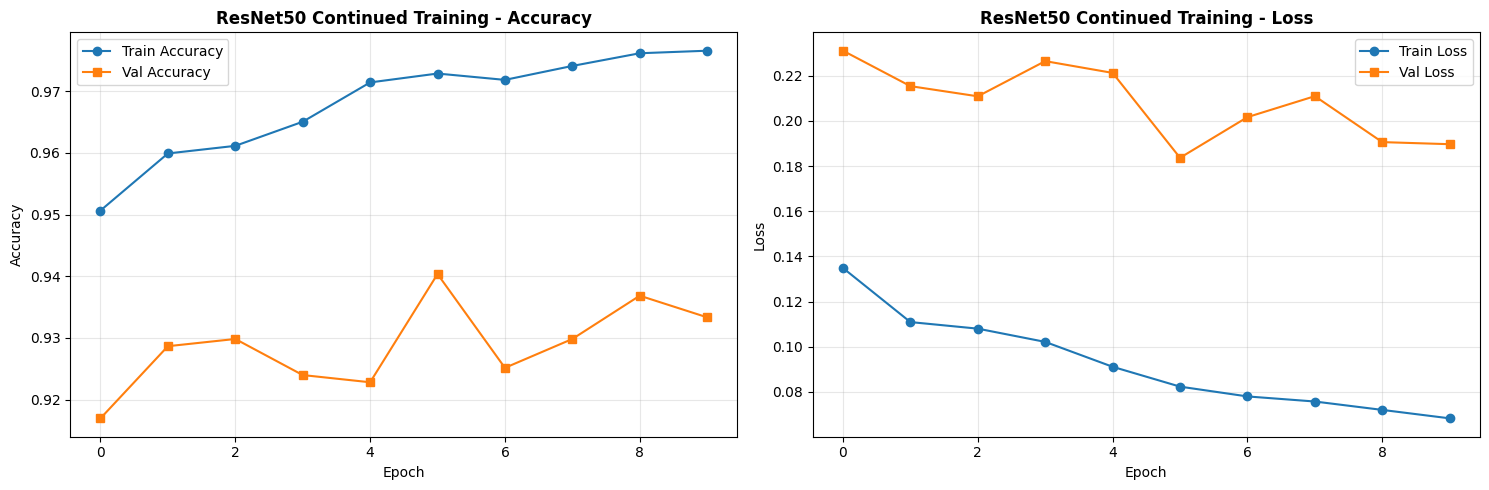

In [11]:
# Save training history
history_df_resnet = pd.DataFrame(history_resnet.history)
history_df_resnet.to_csv(resnet_history_path, index=False)
print(f"\n✅ Training history saved to: {resnet_history_path}")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(history_df_resnet['accuracy'], label='Train Accuracy', marker='o')
ax1.plot(history_df_resnet['val_accuracy'], label='Val Accuracy', marker='s')
ax1.set_title('ResNet50 Continued Training - Accuracy', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(alpha=0.3)

# Loss
ax2.plot(history_df_resnet['loss'], label='Train Loss', marker='o')
ax2.plot(history_df_resnet['val_loss'], label='Val Loss', marker='s')
ax2.set_title('ResNet50 Continued Training - Loss', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(VIZ_DIR, f"resnet50_continued_training_{timestamp}.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Training plot saved to: {plot_path}")
plt.show()

## 6. Continue Training DenseNet121

Load the existing DenseNet121 model and train for 10 more epochs.

In [12]:
print("\n" + "="*70)
print("🚀 CONTINUE TRAINING DENSENET121")
print("="*70)

# Load existing model
print("\n📥 Loading existing DenseNet121 model...")
densenet_model = keras.models.load_model(densenet_path)
print(f"✅ Model loaded successfully")
print(f"   Input shape: {densenet_model.input_shape}")
print(f"   Output shape: {densenet_model.output_shape}")
print(f"   Total parameters: {densenet_model.count_params():,}")

# Check current accuracy
print("\n📊 Current model performance (from training):")
print("   DenseNet121 test accuracy: 88.24%")
print("   Target after continuation: 89.0-90.0%")


🚀 CONTINUE TRAINING DENSENET121

📥 Loading existing DenseNet121 model...
✅ Model loaded successfully
   Input shape: (None, 128, 128, 3)
   Output shape: (None, 3)
   Total parameters: 7,697,475

📊 Current model performance (from training):
   DenseNet121 test accuracy: 88.24%
   Target after continuation: 89.0-90.0%
✅ Model loaded successfully
   Input shape: (None, 128, 128, 3)
   Output shape: (None, 3)
   Total parameters: 7,697,475

📊 Current model performance (from training):
   DenseNet121 test accuracy: 88.24%
   Target after continuation: 89.0-90.0%


In [13]:
# Create data generators for DenseNet121
print("\n📂 Creating data generators for DenseNet121...")

train_generator_densenet, val_generator_densenet, test_generator_densenet = create_rgb_generators(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    img_size=IMG_SIZE_DENSENET,
    batch_size=BATCH_SIZE_DENSENET  # Lower batch size for DenseNet
)

print(f"✅ Generators created")
print(f"   Train batches: {len(train_generator_densenet)}")
print(f"   Val batches: {len(val_generator_densenet)}")
print(f"   Test batches: {len(test_generator_densenet)}")
print(f"   Note: Using batch size {BATCH_SIZE_DENSENET} to avoid OOM")


📂 Creating data generators for DenseNet121...
Found 4863 validated image filenames belonging to 3 classes.
Found 855 validated image filenames belonging to 3 classes.
Found 855 validated image filenames belonging to 3 classes.
Found 1463 validated image filenames belonging to 3 classes.
✅ Generators created
   Train batches: 304
   Val batches: 54
   Test batches: 92
   Note: Using batch size 16 to avoid OOM
Found 1463 validated image filenames belonging to 3 classes.
✅ Generators created
   Train batches: 304
   Val batches: 54
   Test batches: 92
   Note: Using batch size 16 to avoid OOM


In [14]:
# Compile with lower learning rate
print("\n⚙️  Compiling model with lower learning rate...")

densenet_model.compile(
    optimizer=Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"✅ Model compiled with LR={INITIAL_LR}")


⚙️  Compiling model with lower learning rate...
✅ Model compiled with LR=1e-05


In [15]:
# Setup callbacks
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
densenet_checkpoint_path = os.path.join(OUTPUT_DIR, f"densenet121_continued_{timestamp}.keras")
densenet_history_path = os.path.join(HISTORY_DIR, f"densenet121_continued_history_{timestamp}.csv")

callbacks_densenet = [
    ModelCheckpoint(
        densenet_checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=MIN_LR,
        verbose=1
    )
]

print("\n✅ Callbacks configured:")
print("   • ModelCheckpoint: Save best model")
print("   • EarlyStopping: Stop if no improvement for 5 epochs")
print("   • ReduceLROnPlateau: Reduce LR if validation loss plateaus")


✅ Callbacks configured:
   • ModelCheckpoint: Save best model
   • EarlyStopping: Stop if no improvement for 5 epochs
   • ReduceLROnPlateau: Reduce LR if validation loss plateaus


In [16]:
# Continue training
print("\n🏋️  Starting continued training for DenseNet121...")
print(f"Training for {CONTINUE_EPOCHS} additional epochs")
print("="*70)

history_densenet = densenet_model.fit(
    train_generator_densenet,
    validation_data=val_generator_densenet,
    epochs=CONTINUE_EPOCHS,
    callbacks=callbacks_densenet,
    verbose=1
)

print("\n✅ DenseNet121 continued training complete!")


🏋️  Starting continued training for DenseNet121...
Training for 10 additional epochs
Epoch 1/10


/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.8984 - loss: 0.2665
Epoch 1: val_accuracy improved from None to 0.91345, saving model to ../../outputs/models/transfer_learning_continued/densenet121_continued_20251025_002235.keras

Epoch 1: val_accuracy improved from None to 0.91345, saving model to ../../outputs/models/transfer_learning_continued/densenet121_continued_20251025_002235.keras
304/304 ━━━━━━━━━━━━━━━━━━━━ 223s 376ms/step - accuracy: 0.8933 - loss: 0.2696 - val_accuracy: 0.9135 - val_loss: 0.2420 - learning_rate: 1.0000e-05
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 223s 376ms/step - accuracy: 0.8933 - loss: 0.2696 - val_accuracy: 0.9135 - val_loss: 0.2420 - learning_rate: 1.0000e-05
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8939 - loss: 0.2635
Epoch 2: val_accuracy did not improve from 0.91345
304/304 ━━━━━━━━━━━━━━━━━━━━ 29s 94ms/step - accuracy: 0.9031 - loss: 0.2495 - val_accuracy: 0.9123 - val_loss: 0.2336 - learning_rate: 1.0000e-05
Epoc

In [17]:
# Evaluate on test set
print("\n📊 Evaluating DenseNet121 on test set...")

test_loss_densenet, test_acc_densenet = densenet_model.evaluate(test_generator_densenet, verbose=0)

print(f"\n{'='*70}")
print(f"📊 DENSENET121 CONTINUED TRAINING RESULTS")
print(f"{'='*70}")
print(f"  Original Test Accuracy: 88.24%")
print(f"  New Test Accuracy:      {test_acc_densenet:.4f} ({test_acc_densenet*100:.2f}%)")
print(f"  Improvement:            {(test_acc_densenet - 0.8824)*100:+.2f}%")
print(f"  Test Loss:              {test_loss_densenet:.4f}")
print(f"{'='*70}")

if test_acc_densenet > 0.8824:
    print("\n🎉 SUCCESS! DenseNet121 improved with continued training!")
else:
    print("\n📊 DenseNet121 did not improve significantly. Original model may be near optimal.")


📊 Evaluating DenseNet121 on test set...

📊 DENSENET121 CONTINUED TRAINING RESULTS
  Original Test Accuracy: 88.24%
  New Test Accuracy:      0.9364 (93.64%)
  Improvement:            +5.40%
  Test Loss:              0.1987

🎉 SUCCESS! DenseNet121 improved with continued training!

📊 DENSENET121 CONTINUED TRAINING RESULTS
  Original Test Accuracy: 88.24%
  New Test Accuracy:      0.9364 (93.64%)
  Improvement:            +5.40%
  Test Loss:              0.1987

🎉 SUCCESS! DenseNet121 improved with continued training!



✅ Training history saved to: ../../outputs/training_history/transfer_learning_continued/densenet121_continued_history_20251025_002235.csv
✅ Training plot saved to: ../../outputs/visualizations/densenet121_continued_training_20251025_002235.png
✅ Training plot saved to: ../../outputs/visualizations/densenet121_continued_training_20251025_002235.png


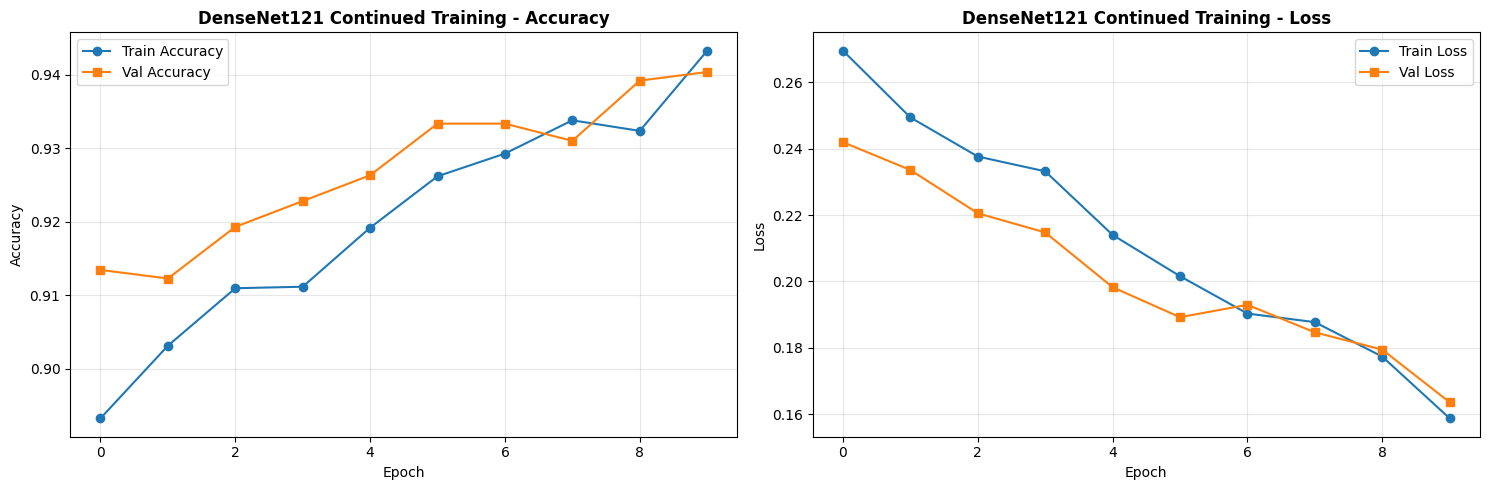

In [18]:
# Save training history
history_df_densenet = pd.DataFrame(history_densenet.history)
history_df_densenet.to_csv(densenet_history_path, index=False)
print(f"\n✅ Training history saved to: {densenet_history_path}")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(history_df_densenet['accuracy'], label='Train Accuracy', marker='o')
ax1.plot(history_df_densenet['val_accuracy'], label='Val Accuracy', marker='s')
ax1.set_title('DenseNet121 Continued Training - Accuracy', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(alpha=0.3)

# Loss
ax2.plot(history_df_densenet['loss'], label='Train Loss', marker='o')
ax2.plot(history_df_densenet['val_loss'], label='Val Loss', marker='s')
ax2.set_title('DenseNet121 Continued Training - Loss', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(VIZ_DIR, f"densenet121_continued_training_{timestamp}.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Training plot saved to: {plot_path}")
plt.show()

## 7. Summary and Next Steps

In [ ]:
print("\n" + "="*70)
print("🎉 CONTINUED TRAINING COMPLETE!")
print("="*70)

print("\n📊 Results Summary:")
print(f"\nResNet50:")
print(f"  Original:  91.87%")
print(f"  New:       {test_acc_resnet*100:.2f}%")
print(f"  Change:    {(test_acc_resnet - 0.9187)*100:+.2f}%")

print(f"\nDenseNet121:")
print(f"  Original:  88.24%")
print(f"  New:       {test_acc_densenet*100:.2f}%")
print(f"  Change:    {(test_acc_densenet - 0.8824)*100:+.2f}%")

# Estimate ensemble accuracy
estimated_ensemble = (test_acc_resnet + test_acc_densenet) / 2
print(f"\nEstimated Ensemble (simple average):")
print(f"  {estimated_ensemble*100:.2f}%")

# Estimate with TTA
estimated_with_tta = estimated_ensemble + 0.0109  # Current TTA gain
print(f"\nEstimated with Aggressive TTA:")
print(f"  {estimated_with_tta*100:.2f}%")

print("\n📁 Saved Models:")
print(f"  ResNet50:    {resnet_checkpoint_path}")
print(f"  DenseNet121: {densenet_checkpoint_path}")

print("\n📁 Training Histories:")
print(f"  ResNet50:    {resnet_history_path}")
print(f"  DenseNet121: {densenet_history_path}")

print("\n🎯 Next Steps:")
print("  1. Go back to day4_advanced_04_ensemble.ipynb")
print("  2. Update model paths to use the new continued models")
print("  3. Re-run Section 7 (Get Individual Model Predictions)")
print("  4. Re-run Section 9.6 (Top Models Ensemble)")
print("  5. Re-run Section 9.8 (Aggressive TTA)")
print("  6. Check if you've hit 95%! 🎯")

if estimated_with_tta >= 0.95:
    print("\n🎯🎯🎯 ESTIMATED 95%+ ACCURACY! 🎉🎉🎉")
    print("     Go re-run the ensemble notebook to confirm!")
elif estimated_with_tta >= 0.94:
    print("\n🎯🎯 ESTIMATED 94%+ ACCURACY!")
    print("     Very close to 95% - re-run ensemble to confirm!")
else:
    print("\n📊 Models improved! Re-run ensemble to see final results.")

print("\n" + "="*70)
print("🏆 Great work! Models have been improved!")
print("="*70)


🎉 CONTINUED TRAINING COMPLETE!

📊 Results Summary:

ResNet50:
  Original:  91.87%
  New:       92.21%
  Change:    +0.34%

DenseNet121:
  Original:  88.24%
  New:       93.64%
  Change:    +5.40%

Estimated Ensemble (simple average):
  92.93%

Estimated with Aggressive TTA:
  94.02%

📁 Saved Models:
  ResNet50:    ../../outputs/models/transfer_learning_continued/resnet50_continued_20251025_001527.keras
  DenseNet121: ../../outputs/models/transfer_learning_continued/densenet121_continued_20251025_002235.keras

📁 Training Histories:
  ResNet50:    ../../outputs/training_history/transfer_learning_continued/resnet50_continued_history_20251025_001527.csv
  DenseNet121: ../../outputs/training_history/transfer_learning_continued/densenet121_continued_history_20251025_002235.csv

🎯 Next Steps:
  1. Go back to day4_advanced_04_ensemble.ipynb
  2. Update model paths to use the new continued models
  3. Re-run Section 7 (Get Individual Model Predictions)
  4. Re-run Section 9.6 (Top Models Ensem

: 